In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(1)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 1
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

cuda:1


In [4]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                           
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


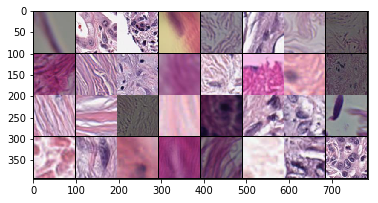

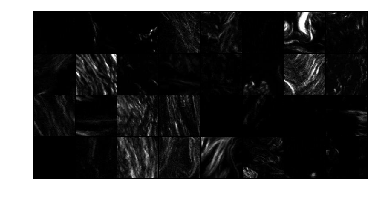

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [9]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -ssim(output, targetf)
        
        p = 0.25
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(p*lossMSE.item()) +
                  " " + "lossSSIM: " + str((1-p)*lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [10]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [11]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.55312180519104 lossSSIM: 0.09154412895441055
===> Epoch[1](0/25343): Loss: 0.6447
lossMSE: 0.5410063862800598 lossSSIM: 0.038698713295161724
===> Epoch[1](50/25343): Loss: 0.5797
lossMSE: 0.5330385565757751 lossSSIM: 0.03606613911688328
===> Epoch[1](100/25343): Loss: 0.5691
lossMSE: 0.5336962342262268 lossSSIM: 0.03544580563902855
===> Epoch[1](150/25343): Loss: 0.5691
lossMSE: 0.5359765291213989 lossSSIM: 0.03296442423015833
===> Epoch[1](200/25343): Loss: 0.5689
lossMSE: 0.5444689989089966 lossSSIM: 0.03329982329159975
===> Epoch[1](250/25343): Loss: 0.5778
lossMSE: 0.547530472278595 lossSSIM: 0.03288355004042387
===> Epoch[1](300/25343): Loss: 0.5804
lossMSE: 0.54599928855896 lossSSIM: 0.03270458243787289
===> Epoch[1](350/25343): Loss: 0.5787
lossMSE: 0.5154597759246826 lossSSIM: 0.0292245140299201
===> Epoch[1](400/25343): Loss: 0.5447
lossMSE: 0.5427029132843018 lossSSIM: 0.03132206294685602
===> Epoch[1](450/25343): Loss: 0.5740
lossMSE: 0.5390594601631165 lossSSIM: 

lossMSE: 0.48203331232070923 lossSSIM: 0.0204996052198112
===> Epoch[1](4200/25343): Loss: 0.5025
lossMSE: 0.4709165394306183 lossSSIM: 0.019796939101070166
===> Epoch[1](4250/25343): Loss: 0.4907
lossMSE: 0.4769511818885803 lossSSIM: 0.020114618819206953
===> Epoch[1](4300/25343): Loss: 0.4971
lossMSE: 0.46059131622314453 lossSSIM: 0.019200285896658897
===> Epoch[1](4350/25343): Loss: 0.4798
lossMSE: 0.4523327052593231 lossSSIM: 0.01911365892738104
===> Epoch[1](4400/25343): Loss: 0.4714
lossMSE: 0.476977676153183 lossSSIM: 0.019653668627142906
===> Epoch[1](4450/25343): Loss: 0.4966
lossMSE: 0.4444836974143982 lossSSIM: 0.01846716133877635
===> Epoch[1](4500/25343): Loss: 0.4630
lossMSE: 0.46950992941856384 lossSSIM: 0.019151566084474325
===> Epoch[1](4550/25343): Loss: 0.4887
lossMSE: 0.4661203920841217 lossSSIM: 0.018746146000921726
===> Epoch[1](4600/25343): Loss: 0.4849
lossMSE: 0.464446485042572 lossSSIM: 0.01860197028145194
===> Epoch[1](4650/25343): Loss: 0.4830
lossMSE: 0.458

lossMSE: 0.4029307961463928 lossSSIM: 0.014420336578041315
===> Epoch[1](8350/25343): Loss: 0.4174
lossMSE: 0.4083258807659149 lossSSIM: 0.014790776185691357
===> Epoch[1](8400/25343): Loss: 0.4231
lossMSE: 0.40046948194503784 lossSSIM: 0.014524780679494143
===> Epoch[1](8450/25343): Loss: 0.4150
lossMSE: 0.403949499130249 lossSSIM: 0.01528982911258936
===> Epoch[1](8500/25343): Loss: 0.4192
lossMSE: 0.39515596628189087 lossSSIM: 0.014898251742124557
===> Epoch[1](8550/25343): Loss: 0.4101
lossMSE: 0.40234625339508057 lossSSIM: 0.014805158134549856
===> Epoch[1](8600/25343): Loss: 0.4172
lossMSE: 0.406789094209671 lossSSIM: 0.014938280917704105
===> Epoch[1](8650/25343): Loss: 0.4217
lossMSE: 0.39999163150787354 lossSSIM: 0.014474612195044756
===> Epoch[1](8700/25343): Loss: 0.4145
lossMSE: 0.40190133452415466 lossSSIM: 0.015689320396631956
===> Epoch[1](8750/25343): Loss: 0.4176
lossMSE: 0.40312710404396057 lossSSIM: 0.015228666365146637
===> Epoch[1](8800/25343): Loss: 0.4184
lossMSE

lossMSE: 0.36132708191871643 lossSSIM: 0.012679513078182936
===> Epoch[1](12500/25343): Loss: 0.3740
lossMSE: 0.34768998622894287 lossSSIM: 0.012233261950314045
===> Epoch[1](12550/25343): Loss: 0.3599
lossMSE: 0.353006511926651 lossSSIM: 0.011968990322202444
===> Epoch[1](12600/25343): Loss: 0.3650
lossMSE: 0.34948137402534485 lossSSIM: 0.012035249266773462
===> Epoch[1](12650/25343): Loss: 0.3615
lossMSE: 0.3593304455280304 lossSSIM: 0.012321010697633028
===> Epoch[1](12700/25343): Loss: 0.3717
lossMSE: 0.3583146929740906 lossSSIM: 0.012237225193530321
===> Epoch[1](12750/25343): Loss: 0.3706
lossMSE: 0.3400338292121887 lossSSIM: 0.011521437903866172
===> Epoch[1](12800/25343): Loss: 0.3516
lossMSE: 0.34438419342041016 lossSSIM: 0.011591232614591718
===> Epoch[1](12850/25343): Loss: 0.3560
lossMSE: 0.3461853265762329 lossSSIM: 0.011709776474162936
===> Epoch[1](12900/25343): Loss: 0.3579
lossMSE: 0.34080836176872253 lossSSIM: 0.012139106635004282
===> Epoch[1](12950/25343): Loss: 0.3

lossMSE: 0.31032148003578186 lossSSIM: 0.009651584085077047
===> Epoch[1](16600/25343): Loss: 0.3200
lossMSE: 0.32437318563461304 lossSSIM: 0.009930086089298129
===> Epoch[1](16650/25343): Loss: 0.3343
lossMSE: 0.31466758251190186 lossSSIM: 0.009192116791382432
===> Epoch[1](16700/25343): Loss: 0.3239
lossMSE: 0.30461323261260986 lossSSIM: 0.009116329718381166
===> Epoch[1](16750/25343): Loss: 0.3137
lossMSE: 0.32156404852867126 lossSSIM: 0.009549497393891215
===> Epoch[1](16800/25343): Loss: 0.3311
lossMSE: 0.32431215047836304 lossSSIM: 0.009731866652145982
===> Epoch[1](16850/25343): Loss: 0.3340
lossMSE: 0.32477834820747375 lossSSIM: 0.009508784394711256
===> Epoch[1](16900/25343): Loss: 0.3343
lossMSE: 0.31689515709877014 lossSSIM: 0.009460994973778725
===> Epoch[1](16950/25343): Loss: 0.3264
lossMSE: 0.32080018520355225 lossSSIM: 0.009358350187540054
===> Epoch[1](17000/25343): Loss: 0.3302
lossMSE: 0.30928242206573486 lossSSIM: 0.00942165800370276
===> Epoch[1](17050/25343): Loss

lossMSE: 0.29915231466293335 lossSSIM: 0.007641069358214736
===> Epoch[1](20700/25343): Loss: 0.3068
lossMSE: 0.29342085123062134 lossSSIM: 0.007748437346890569
===> Epoch[1](20750/25343): Loss: 0.3012
lossMSE: 0.29924213886260986 lossSSIM: 0.0076236475724726915
===> Epoch[1](20800/25343): Loss: 0.3069
lossMSE: 0.3030959963798523 lossSSIM: 0.0077877414878457785
===> Epoch[1](20850/25343): Loss: 0.3109
lossMSE: 0.30168846249580383 lossSSIM: 0.007778658298775554
===> Epoch[1](20900/25343): Loss: 0.3095
lossMSE: 0.29245322942733765 lossSSIM: 0.007394968997687101
===> Epoch[1](20950/25343): Loss: 0.2998
lossMSE: 0.297810822725296 lossSSIM: 0.0077608146239072084
===> Epoch[1](21000/25343): Loss: 0.3056
lossMSE: 0.2866304814815521 lossSSIM: 0.0074497677851468325
===> Epoch[1](21050/25343): Loss: 0.2941
lossMSE: 0.29145294427871704 lossSSIM: 0.0076098027639091015
===> Epoch[1](21100/25343): Loss: 0.2991
lossMSE: 0.29832038283348083 lossSSIM: 0.007459858199581504
===> Epoch[1](21150/25343): Lo

lossMSE: 0.2735878825187683 lossSSIM: 0.006662463303655386
===> Epoch[1](24800/25343): Loss: 0.2803
lossMSE: 0.26489582657814026 lossSSIM: 0.006710172398015857
===> Epoch[1](24850/25343): Loss: 0.2716
lossMSE: 0.2766674757003784 lossSSIM: 0.006714101415127516
===> Epoch[1](24900/25343): Loss: 0.2834
lossMSE: 0.2822265625 lossSSIM: 0.006441421341150999
===> Epoch[1](24950/25343): Loss: 0.2887
lossMSE: 0.27360448241233826 lossSSIM: 0.006358852609992027
===> Epoch[1](25000/25343): Loss: 0.2800
lossMSE: 0.27499353885650635 lossSSIM: 0.006454150658100843
===> Epoch[1](25050/25343): Loss: 0.2814
lossMSE: 0.26721060276031494 lossSSIM: 0.006146313389763236
===> Epoch[1](25100/25343): Loss: 0.2734
lossMSE: 0.28632885217666626 lossSSIM: 0.0063989725895226
===> Epoch[1](25150/25343): Loss: 0.2927
lossMSE: 0.27198222279548645 lossSSIM: 0.00650953478179872
===> Epoch[1](25200/25343): Loss: 0.2785
lossMSE: 0.2594829797744751 lossSSIM: 0.006345824338495731
===> Epoch[1](25250/25343): Loss: 0.2658
los

lossMSE: 0.2658270597457886 lossSSIM: 0.007024663500487804
===> Epoch[2](3600/25343): Loss: 0.2729
lossMSE: 0.263240784406662 lossSSIM: 0.007050092797726393
===> Epoch[2](3650/25343): Loss: 0.2703
lossMSE: 0.25144636631011963 lossSSIM: 0.006976183271035552
===> Epoch[2](3700/25343): Loss: 0.2584
lossMSE: 0.25528356432914734 lossSSIM: 0.0071487820241600275
===> Epoch[2](3750/25343): Loss: 0.2624
lossMSE: 0.266559362411499 lossSSIM: 0.007510294206440449
===> Epoch[2](3800/25343): Loss: 0.2741
lossMSE: 0.26060423254966736 lossSSIM: 0.00718497228808701
===> Epoch[2](3850/25343): Loss: 0.2678
lossMSE: 0.26263362169265747 lossSSIM: 0.007336917333304882
===> Epoch[2](3900/25343): Loss: 0.2700
lossMSE: 0.26104041934013367 lossSSIM: 0.0077569296117872
===> Epoch[2](3950/25343): Loss: 0.2688
lossMSE: 0.2673031985759735 lossSSIM: 0.007404440548270941
===> Epoch[2](4000/25343): Loss: 0.2747
lossMSE: 0.2629409432411194 lossSSIM: 0.007435637293383479
===> Epoch[2](4050/25343): Loss: 0.2704
lossMSE: 

lossMSE: 0.25667038559913635 lossSSIM: 0.00632929103448987
===> Epoch[2](7750/25343): Loss: 0.2630
lossMSE: 0.2522680461406708 lossSSIM: 0.006056446814909577
===> Epoch[2](7800/25343): Loss: 0.2583
lossMSE: 0.2472071349620819 lossSSIM: 0.005842101294547319
===> Epoch[2](7850/25343): Loss: 0.2530
lossMSE: 0.2531978487968445 lossSSIM: 0.005917279282584786
===> Epoch[2](7900/25343): Loss: 0.2591
lossMSE: 0.2459172159433365 lossSSIM: 0.005841075209900737
===> Epoch[2](7950/25343): Loss: 0.2518
lossMSE: 0.25489792227745056 lossSSIM: 0.006228910759091377
===> Epoch[2](8000/25343): Loss: 0.2611
lossMSE: 0.2550753653049469 lossSSIM: 0.0061835842207074165
===> Epoch[2](8050/25343): Loss: 0.2613
lossMSE: 0.2413206398487091 lossSSIM: 0.005996296880766749
===> Epoch[2](8100/25343): Loss: 0.2473
lossMSE: 0.25080597400665283 lossSSIM: 0.0058164107613265514
===> Epoch[2](8150/25343): Loss: 0.2566
lossMSE: 0.25638094544410706 lossSSIM: 0.006200821604579687
===> Epoch[2](8200/25343): Loss: 0.2626
lossM

lossMSE: 0.24331140518188477 lossSSIM: 0.005343604367226362
===> Epoch[2](11850/25343): Loss: 0.2487
lossMSE: 0.2526909410953522 lossSSIM: 0.005508422269485891
===> Epoch[2](11900/25343): Loss: 0.2582
lossMSE: 0.23921377956867218 lossSSIM: 0.0050526391714811325
===> Epoch[2](11950/25343): Loss: 0.2443
lossMSE: 0.24630896747112274 lossSSIM: 0.005267932894639671
===> Epoch[2](12000/25343): Loss: 0.2516
lossMSE: 0.2418650984764099 lossSSIM: 0.005159937660209835
===> Epoch[2](12050/25343): Loss: 0.2470
lossMSE: 0.2421204298734665 lossSSIM: 0.0050445799715816975
===> Epoch[2](12100/25343): Loss: 0.2472
lossMSE: 0.24540495872497559 lossSSIM: 0.005207296111620963
===> Epoch[2](12150/25343): Loss: 0.2506
lossMSE: 0.24650001525878906 lossSSIM: 0.005147462245076895
===> Epoch[2](12200/25343): Loss: 0.2516
lossMSE: 0.2484501153230667 lossSSIM: 0.005263403174467385
===> Epoch[2](12250/25343): Loss: 0.2537
lossMSE: 0.24780869483947754 lossSSIM: 0.005339734721928835
===> Epoch[2](12300/25343): Loss:

lossMSE: 0.24181178212165833 lossSSIM: 0.004537327797152102
===> Epoch[2](15950/25343): Loss: 0.2463
lossMSE: 0.244329035282135 lossSSIM: 0.004463037243112922
===> Epoch[2](16000/25343): Loss: 0.2488
lossMSE: 0.24153906106948853 lossSSIM: 0.004316124483011663
===> Epoch[2](16050/25343): Loss: 0.2459
lossMSE: 0.24667586386203766 lossSSIM: 0.004500317154452205
===> Epoch[2](16100/25343): Loss: 0.2512
lossMSE: 0.23080846667289734 lossSSIM: 0.0040725222788751125
===> Epoch[2](16150/25343): Loss: 0.2349
lossMSE: 0.24847708642482758 lossSSIM: 0.004579160129651427
===> Epoch[2](16200/25343): Loss: 0.2531
lossMSE: 0.23565419018268585 lossSSIM: 0.004105501226149499
===> Epoch[2](16250/25343): Loss: 0.2398
lossMSE: 0.2416384518146515 lossSSIM: 0.004341308958828449
===> Epoch[2](16300/25343): Loss: 0.2460
lossMSE: 0.23867267370224 lossSSIM: 0.004207329824566841
===> Epoch[2](16350/25343): Loss: 0.2429
lossMSE: 0.2431582361459732 lossSSIM: 0.004227716010063887
===> Epoch[2](16400/25343): Loss: 0.2

lossMSE: 0.24167916178703308 lossSSIM: 0.0057414856273680925
===> Epoch[2](20050/25343): Loss: 0.2474
lossMSE: 0.2458818554878235 lossSSIM: 0.00570455496199429
===> Epoch[2](20100/25343): Loss: 0.2516
lossMSE: 0.23666079342365265 lossSSIM: 0.0053787968354299664
===> Epoch[2](20150/25343): Loss: 0.2420
lossMSE: 0.22724172472953796 lossSSIM: 0.004625042667612433
===> Epoch[2](20200/25343): Loss: 0.2319
lossMSE: 0.242215096950531 lossSSIM: 0.005465487018227577
===> Epoch[2](20250/25343): Loss: 0.2477
lossMSE: 0.23537315428256989 lossSSIM: 0.005263923201709986
===> Epoch[2](20300/25343): Loss: 0.2406
lossMSE: 0.2391531765460968 lossSSIM: 0.005072818603366613
===> Epoch[2](20350/25343): Loss: 0.2442
lossMSE: 0.23416975140571594 lossSSIM: 0.005668695084750652
===> Epoch[2](20400/25343): Loss: 0.2398
lossMSE: 0.2384093552827835 lossSSIM: 0.005109338206239045
===> Epoch[2](20450/25343): Loss: 0.2435
lossMSE: 0.2252708226442337 lossSSIM: 0.004823883413337171
===> Epoch[2](20500/25343): Loss: 0.

lossMSE: 0.21656686067581177 lossSSIM: 0.004470708779990673
===> Epoch[2](24150/25343): Loss: 0.2210
lossMSE: 0.23237191140651703 lossSSIM: 0.00538510421756655
===> Epoch[2](24200/25343): Loss: 0.2378
lossMSE: 0.2333381474018097 lossSSIM: 0.005232191062532365
===> Epoch[2](24250/25343): Loss: 0.2386
lossMSE: 0.23339799046516418 lossSSIM: 0.00537955854088068
===> Epoch[2](24300/25343): Loss: 0.2388
lossMSE: 0.21846148371696472 lossSSIM: 0.004405622254125774
===> Epoch[2](24350/25343): Loss: 0.2229
lossMSE: 0.23052279651165009 lossSSIM: 0.005634646746329963
===> Epoch[2](24400/25343): Loss: 0.2362
lossMSE: 0.22547486424446106 lossSSIM: 0.005187810631468892
===> Epoch[2](24450/25343): Loss: 0.2307
lossMSE: 0.23665720224380493 lossSSIM: 0.005385954980738461
===> Epoch[2](24500/25343): Loss: 0.2420
lossMSE: 0.23788268864154816 lossSSIM: 0.005878424970433116
===> Epoch[2](24550/25343): Loss: 0.2438
lossMSE: 0.22726723551750183 lossSSIM: 0.005005200393497944
===> Epoch[2](24600/25343): Loss: 

lossMSE: 0.23116731643676758 lossSSIM: 0.004431350156664848
===> Epoch[3](2900/25343): Loss: 0.2356
lossMSE: 0.22633647918701172 lossSSIM: 0.004251714795827866
===> Epoch[3](2950/25343): Loss: 0.2306
lossMSE: 0.22823725640773773 lossSSIM: 0.004244620562531054
===> Epoch[3](3000/25343): Loss: 0.2325
lossMSE: 0.23106122016906738 lossSSIM: 0.004350816132500768
===> Epoch[3](3050/25343): Loss: 0.2354
lossMSE: 0.22670957446098328 lossSSIM: 0.004128786502406001
===> Epoch[3](3100/25343): Loss: 0.2308
lossMSE: 0.2261074334383011 lossSSIM: 0.00417135120369494
===> Epoch[3](3150/25343): Loss: 0.2303
lossMSE: 0.2316904067993164 lossSSIM: 0.004470729036256671
===> Epoch[3](3200/25343): Loss: 0.2362
lossMSE: 0.22879928350448608 lossSSIM: 0.0042242619674652815
===> Epoch[3](3250/25343): Loss: 0.2330
lossMSE: 0.22064198553562164 lossSSIM: 0.0037748697213828564
===> Epoch[3](3300/25343): Loss: 0.2244
lossMSE: 0.2301415055990219 lossSSIM: 0.004146795719861984
===> Epoch[3](3350/25343): Loss: 0.2343
lo

lossMSE: 0.21815316379070282 lossSSIM: 0.002694762486498803
===> Epoch[3](7000/25343): Loss: 0.2208
lossMSE: 0.22842495143413544 lossSSIM: 0.003005849663168192
===> Epoch[3](7050/25343): Loss: 0.2314
lossMSE: 0.23322802782058716 lossSSIM: 0.003142344066873193
===> Epoch[3](7100/25343): Loss: 0.2364
lossMSE: 0.2214558869600296 lossSSIM: 0.0027565666241571307
===> Epoch[3](7150/25343): Loss: 0.2242
lossMSE: 0.2298845648765564 lossSSIM: 0.00308498356025666
===> Epoch[3](7200/25343): Loss: 0.2330
lossMSE: 0.2275756150484085 lossSSIM: 0.0029122447595000267
===> Epoch[3](7250/25343): Loss: 0.2305
lossMSE: 0.21888457238674164 lossSSIM: 0.0027181165642105043
===> Epoch[3](7300/25343): Loss: 0.2216
lossMSE: 0.23294708132743835 lossSSIM: 0.003067340701818466
===> Epoch[3](7350/25343): Loss: 0.2360
lossMSE: 0.2317664921283722 lossSSIM: 0.0030204757349565625
===> Epoch[3](7400/25343): Loss: 0.2348
lossMSE: 0.2218090146780014 lossSSIM: 0.0026634595706127584
===> Epoch[3](7450/25343): Loss: 0.2245
l

lossMSE: 0.22323989868164062 lossSSIM: 0.0020150014897808433
===> Epoch[3](11100/25343): Loss: 0.2253
lossMSE: 0.23126894235610962 lossSSIM: 0.002146327227819711
===> Epoch[3](11150/25343): Loss: 0.2334
lossMSE: 0.22605054080486298 lossSSIM: 0.0019881058833561838
===> Epoch[3](11200/25343): Loss: 0.2280
lossMSE: 0.2248346209526062 lossSSIM: 0.0019602501997724175
===> Epoch[3](11250/25343): Loss: 0.2268
lossMSE: 0.22638951241970062 lossSSIM: 0.002046979498118162
===> Epoch[3](11300/25343): Loss: 0.2284
lossMSE: 0.2218206226825714 lossSSIM: 0.0019737452385015786
===> Epoch[3](11350/25343): Loss: 0.2238
lossMSE: 0.22917386889457703 lossSSIM: 0.0020596541580744088
===> Epoch[3](11400/25343): Loss: 0.2312
lossMSE: 0.23003405332565308 lossSSIM: 0.0021292594028636813
===> Epoch[3](11450/25343): Loss: 0.2322
lossMSE: 0.22514308989048004 lossSSIM: 0.0019135139300487936
===> Epoch[3](11500/25343): Loss: 0.2271
lossMSE: 0.23402541875839233 lossSSIM: 0.002176259004045278
===> Epoch[3](11550/25343)

lossMSE: 0.231614887714386 lossSSIM: 0.0015576024306938052
===> Epoch[3](15150/25343): Loss: 0.2332
lossMSE: 0.22786930203437805 lossSSIM: 0.0014743896899744868
===> Epoch[3](15200/25343): Loss: 0.2293
lossMSE: 0.23264139890670776 lossSSIM: 0.0015895214164629579
===> Epoch[3](15250/25343): Loss: 0.2342
lossMSE: 0.22596757113933563 lossSSIM: 0.00141961665940471
===> Epoch[3](15300/25343): Loss: 0.2274
lossMSE: 0.22833064198493958 lossSSIM: 0.0015350051689893007
===> Epoch[3](15350/25343): Loss: 0.2299
lossMSE: 0.23057399690151215 lossSSIM: 0.001497404824476689
===> Epoch[3](15400/25343): Loss: 0.2321
lossMSE: 0.22116811573505402 lossSSIM: 0.0013090682623442262
===> Epoch[3](15450/25343): Loss: 0.2225
lossMSE: 0.22021861374378204 lossSSIM: 0.001277941366424784
===> Epoch[3](15500/25343): Loss: 0.2215
lossMSE: 0.21986989676952362 lossSSIM: 0.001266009989194572
===> Epoch[3](15550/25343): Loss: 0.2211
lossMSE: 0.23655949532985687 lossSSIM: 0.001563594094477594
===> Epoch[3](15600/25343): L

lossMSE: 0.22152361273765564 lossSSIM: 0.0009554811695124954
===> Epoch[3](19200/25343): Loss: 0.2225
lossMSE: 0.22335569560527802 lossSSIM: 0.0010121562809217721
===> Epoch[3](19250/25343): Loss: 0.2244
lossMSE: 0.22415345907211304 lossSSIM: 0.0009740852401591837
===> Epoch[3](19300/25343): Loss: 0.2251
lossMSE: 0.2292805314064026 lossSSIM: 0.0010435566364321858
===> Epoch[3](19350/25343): Loss: 0.2303
lossMSE: 0.22093388438224792 lossSSIM: 0.0009420780697837472
===> Epoch[3](19400/25343): Loss: 0.2219
lossMSE: 0.21794183552265167 lossSSIM: 0.0009000611607916653
===> Epoch[3](19450/25343): Loss: 0.2188
lossMSE: 0.22847706079483032 lossSSIM: 0.001026005280436948
===> Epoch[3](19500/25343): Loss: 0.2295
lossMSE: 0.2294161021709442 lossSSIM: 0.0010689006303437054
===> Epoch[3](19550/25343): Loss: 0.2305
lossMSE: 0.21721778810024261 lossSSIM: 0.000918981822906062
===> Epoch[3](19600/25343): Loss: 0.2181
lossMSE: 0.22384993731975555 lossSSIM: 0.00093024832312949
===> Epoch[3](19650/25343):

lossMSE: 0.21318119764328003 lossSSIM: 0.000647676904918626
===> Epoch[3](23250/25343): Loss: 0.2138
lossMSE: 0.2323644906282425 lossSSIM: 0.0008036282379180193
===> Epoch[3](23300/25343): Loss: 0.2332
lossMSE: 0.2302936464548111 lossSSIM: 0.0007649296894669533
===> Epoch[3](23350/25343): Loss: 0.2311
lossMSE: 0.2187175154685974 lossSSIM: 0.0006699018704239279
===> Epoch[3](23400/25343): Loss: 0.2194
lossMSE: 0.22956402599811554 lossSSIM: 0.0007580939854960889
===> Epoch[3](23450/25343): Loss: 0.2303
lossMSE: 0.22569707036018372 lossSSIM: 0.0007330843072850257
===> Epoch[3](23500/25343): Loss: 0.2264
lossMSE: 0.2308565229177475 lossSSIM: 0.0007580450910609215
===> Epoch[3](23550/25343): Loss: 0.2316
lossMSE: 0.22367647290229797 lossSSIM: 0.0006934802077012137
===> Epoch[3](23600/25343): Loss: 0.2244
lossMSE: 0.2253076434135437 lossSSIM: 0.0007282158185262233
===> Epoch[3](23650/25343): Loss: 0.2260
lossMSE: 0.22476966679096222 lossSSIM: 0.0007022712525213137
===> Epoch[3](23700/25343):

lossMSE: 0.2226698398590088 lossSSIM: 0.0005207560752751306
===> Epoch[4](1950/25343): Loss: 0.2232
lossMSE: 0.22206862270832062 lossSSIM: 0.0005467512382892892
===> Epoch[4](2000/25343): Loss: 0.2226
lossMSE: 0.22352589666843414 lossSSIM: 0.0005255140276858583
===> Epoch[4](2050/25343): Loss: 0.2241
lossMSE: 0.22597964107990265 lossSSIM: 0.0005360343639040366
===> Epoch[4](2100/25343): Loss: 0.2265
lossMSE: 0.2367711365222931 lossSSIM: 0.0005929038743488491
===> Epoch[4](2150/25343): Loss: 0.2374
lossMSE: 0.22755061089992523 lossSSIM: 0.0005471191689139232
===> Epoch[4](2200/25343): Loss: 0.2281
lossMSE: 0.22169074416160583 lossSSIM: 0.000528471966390498
===> Epoch[4](2250/25343): Loss: 0.2222
lossMSE: 0.2285984605550766 lossSSIM: 0.0005321591743268073
===> Epoch[4](2300/25343): Loss: 0.2291
lossMSE: 0.22376006841659546 lossSSIM: 0.0005139491404406726
===> Epoch[4](2350/25343): Loss: 0.2243
lossMSE: 0.22275368869304657 lossSSIM: 0.000501227768836543
===> Epoch[4](2400/25343): Loss: 0.